## Stay Days Analysis with PROCEDURES

What is the relationship between the patient data and the stay days in ICU?

In [182]:
# Import Libraries
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Pre-processing
import kardiasclean
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# KMeans Cluster
from sklearn.cluster import KMeans

In [183]:
# Load Data
path2 = Path("../database/clean2")
df = pd.read_csv(path2 / "db_patient.csv")
df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,date_birth,date_procedure,rachs,stay_days,expired
0,0,0,3942,35.0,134.0,0,2001-08-22,2012-04-08,1,2,0
1,1,1,3202,18.0,117.0,0,2003-09-19,2012-11-08,1,2,0
2,2,0,3147,22.0,120.0,0,2003-11-21,2012-08-18,1,2,0
3,3,0,4005,42.0,147.0,0,2001-10-07,2012-08-25,1,2,0
4,4,0,5289,40.0,157.0,0,1997-12-22,2012-01-09,1,3,0


In [184]:
# Select feature columns for clustering
columns = [
    "patient_id",
    "gender",
    "age_days", 
    "weight_kg", 
    "height_cm", 
    "cx_previous",
    "rachs",
    "stay_days",
]
df = df[columns]
df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,rachs,stay_days
0,0,0,3942,35.0,134.0,0,1,2
1,1,1,3202,18.0,117.0,0,1,2
2,2,0,3147,22.0,120.0,0,1,2
3,3,0,4005,42.0,147.0,0,1,2
4,4,0,5289,40.0,157.0,0,1,3


Include the Diagnosis Data

In [185]:
# Load additional columns: DIAGNOSIS
df2 = pd.read_csv("../database/clean3/db_patient_surgical_procedure_category.csv")
df2.dropna(inplace=True)
df2.head()

,patient_id,surgical_procedure,category_procedure
0,0,Reparacion de CIA parche,Parche comunicacion interauricular CIA
1,1,Reparacion de CIA parche,Parche comunicacion interauricular CIA
2,2,Reparacion de CIA parche,Parche comunicacion interauricular CIA
3,3,Reparacion de CIA parche,Parche comunicacion interauricular CIA
4,4,Reparacion de CIA parche,Parche comunicacion interauricular CIA


In [186]:
df2['category_procedure'].value_counts()[0:20]

Other                                                                    594
Vena cava inferior parche                                                186
Parche comunicacion interauricular CIA                                   174
Cierre de Conducto Arterioso                                             101
Reparacion de Tetralogia de Fallot                                        90
Procedimiento de Glenn                                                    63
Reparacion de arco aortico                                                56
Procedimiento de Fontan                                                   54
Fistula sistemico pulmonar                                                43
Reparacion de Canal AV                                                    40
Reparacion de conexion anomala total de venas pulmonares                  39
Bandaje de la AP                                                          26
Plastia mitral                                                            25

In [187]:
THRESHOLD = 40
df2["category_procedure"] = kardiasclean.perform_binning_scalar(df2["category_procedure"], THRESHOLD)
encoded_df = kardiasclean.perform_matrix_encoding(df2["category_procedure"], df2["patient_id"], append_name=False)
print(encoded_df.shape)
encoded_df.head()

(1003, 11)


,patient_id,Parche comunicacion interauricular CIA,Vena cava inferior parche,Other,Cierre de Conducto Arterioso,Reparacion de Canal AV,Reparacion de Tetralogia de Fallot,Procedimiento de Glenn,Reparacion de arco aortico,Fistula sistemico pulmonar,Procedimiento de Fontan
0,0,1,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,0,0,0,0,0
4,4,1,0,0,0,0,0,0,0,0,0


In [188]:
# Merge encoded data with original
merged_df = pd.merge(df, encoded_df)
merged_df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,rachs,stay_days,Parche comunicacion interauricular CIA,Vena cava inferior parche,Other,Cierre de Conducto Arterioso,Reparacion de Canal AV,Reparacion de Tetralogia de Fallot,Procedimiento de Glenn,Reparacion de arco aortico,Fistula sistemico pulmonar,Procedimiento de Fontan
0,0,0,3942,35.0,134.0,0,1,2,1,0,0,0,0,0,0,0,0,0
1,1,1,3202,18.0,117.0,0,1,2,1,0,0,0,0,0,0,0,0,0
2,2,0,3147,22.0,120.0,0,1,2,1,0,0,0,0,0,0,0,0,0
3,3,0,4005,42.0,147.0,0,1,2,1,0,0,0,0,0,0,0,0,0
4,4,0,5289,40.0,157.0,0,1,3,1,0,0,0,0,0,0,0,0,0


## Principal Component Analysis

Do we have a good amount of features to make a prediction?

(Change the Binning Threshold depending on PCA evaluation)

In [189]:
y = merged_df["stay_days"]
X = merged_df.drop(columns=["stay_days"])
X_scaled = StandardScaler().fit_transform(X)
X_scaled.shape

(1003, 17)

0.9860250315141781

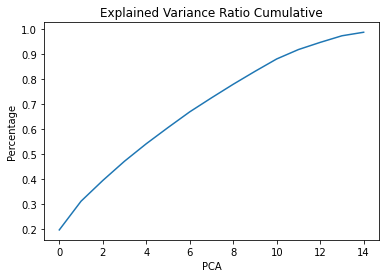

In [190]:
# Evaluate PCA
def get_explained_variance_ratio(df: pd.DataFrame, n_components: int):
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(df)
    return data, np.asarray(pca.explained_variance_ratio_)

N_COMPONENTS = 15
data, evr = get_explained_variance_ratio(X_scaled, N_COMPONENTS)
X_pca = pd.DataFrame(data, columns=[f"PC{x+1}" for x in range(N_COMPONENTS)])

plt.plot(np.cumsum(evr))
plt.title("Explained Variance Ratio Cumulative")
plt.xlabel("PCA")
plt.ylabel("Percentage")
sum(evr)

**CONCLUSION:** We are not going to use the PCA, because the cleaning was good.

## KMeans Clustering

Apply a Clustering Algorithm.

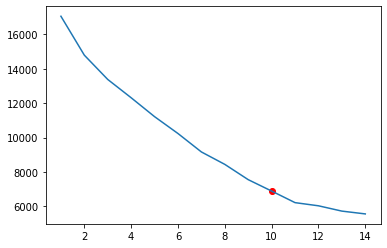

In [191]:
# Plot the Elbow curve
sse = pd.Series({k: KMeans(n_clusters=k).fit(X_scaled).inertia_ for k in range(1, 15)})
N_CLUSTERS = 10
plt.scatter(N_CLUSTERS, sse[N_CLUSTERS], color="red")
plt.plot(sse.index, sse.values)

In [192]:
# Create Clusters
model = KMeans(n_clusters=N_CLUSTERS, random_state=1).fit(X_scaled)
clusters = pd.Series(model.predict(X_scaled))
print("Patients per Cluster")
clusters.value_counts().sort_index()

Patients per Cluster


0     79
1     86
2    132
3     54
4     48
5     51
6    155
7     42
8    316
9     40
dtype: int64

In [193]:
# Merge with ORIGINAL DATA
clustered_df = merged_df.copy(deep=True)
clustered_df["cluster"] = clusters
clustered_df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,rachs,stay_days,Parche comunicacion interauricular CIA,Vena cava inferior parche,Other,Cierre de Conducto Arterioso,Reparacion de Canal AV,Reparacion de Tetralogia de Fallot,Procedimiento de Glenn,Reparacion de arco aortico,Fistula sistemico pulmonar,Procedimiento de Fontan,cluster
0,0,0,3942,35.0,134.0,0,1,2,1,0,0,0,0,0,0,0,0,0,2
1,1,1,3202,18.0,117.0,0,1,2,1,0,0,0,0,0,0,0,0,0,2
2,2,0,3147,22.0,120.0,0,1,2,1,0,0,0,0,0,0,0,0,0,2
3,3,0,4005,42.0,147.0,0,1,2,1,0,0,0,0,0,0,0,0,0,2
4,4,0,5289,40.0,157.0,0,1,3,1,0,0,0,0,0,0,0,0,0,2


Text(0, 0.5, 'Average Stay Days')

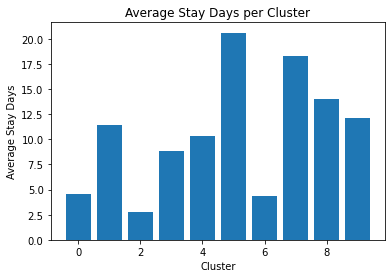

In [194]:
# Look at clusters
plot_data = clustered_df.groupby("cluster").mean()["stay_days"]
plot_x = plot_data.index
plot_y = plot_data.values
plt.bar(plot_x, plot_y)
plt.title("Average Stay Days per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Stay Days")

In [195]:
# Create a Table of mean values per cluster
cluster_mean_df = pd.DataFrame()
target_names = ["stay_days", "rachs", "cx_previous", "age_days"]

# Process each cluster's data
for i in range(N_CLUSTERS):
    c_df = clustered_df[clustered_df["cluster"] == i]
    targets = [c_df[t].mean() for t in target_names]
    cluster_mean_df[f"Cluster {i+1}"] = [c_df.count()[0], *targets]

# Rename Index
cluster_mean_df.index = ["n_patients", *target_names]
# Transpose and Sort Data
sort_by = "stay_days"
cluster_mean_df = cluster_mean_df.transpose().sort_values(by=sort_by)
print("Table of Cluster x Mean Values")
cluster_mean_df

Table of Cluster x Mean Values


,n_patients,stay_days,rachs,cx_previous,age_days
Cluster 3,132.0,2.757576,1.083333,0.037879,2308.628788
Cluster 7,155.0,4.354839,2.038710,0.045161,1006.612903
Cluster 1,79.0,4.556962,1.911392,0.215190,4906.164557
Cluster 4,54.0,8.814815,2.277778,0.314815,849.518519
Cluster 5,48.0,10.354167,2.875000,1.729167,2345.666667
Cluster 2,86.0,11.453488,2.058140,0.058140,965.523256
Cluster 10,40.0,12.100000,2.775000,0.100000,720.225000
Cluster 9,316.0,14.056962,2.202532,0.104430,854.838608
Cluster 8,42.0,18.261905,2.785714,0.333333,398.857143
Cluster 6,51.0,20.607843,4.019608,0.019608,286.862745


In [196]:
# Getting More stats per Column, spread in different tables
target_stats = ["mean", "std", "min", "max"]
for i in range(N_CLUSTERS):
    print("CLUSTER:", i)
    d = clustered_df[clustered_df["cluster"] == i]
    print(d[target_names].describe().loc[target_stats])

CLUSTER: 0
      stay_days     rachs  cx_previous      age_days
mean   4.556962  1.911392      0.21519   4906.164557
std    5.527894  0.865135      0.52308   2108.295857
min    0.000000  0.000000      0.00000   2440.000000
max   39.000000  4.000000      2.00000  16378.000000
CLUSTER: 1
       stay_days    rachs  cx_previous     age_days
mean   11.453488  2.05814      0.05814   965.523256
std    23.401185  0.23538      0.23538   809.145747
min     1.000000  2.00000      0.00000    67.000000
max   213.000000  3.00000      1.00000  3871.000000
CLUSTER: 2
      stay_days     rachs  cx_previous     age_days
mean   2.757576  1.083333     0.037879  2308.628788
std    1.958038  0.350391     0.191630  1121.152205
min    1.000000  0.000000     0.000000   264.000000
max   19.000000  3.000000     1.000000  5289.000000
CLUSTER: 3
      stay_days     rachs  cx_previous     age_days
mean   8.814815  2.277778     0.314815   849.518519
std    7.087257  0.492076     0.468803   785.858304
min    2.000000

Text(0.5, 1.0, 'Clusters Stay Days vs Rachs')

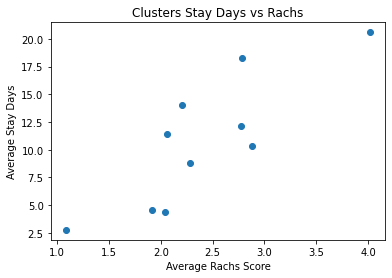

In [197]:
# Visualize stay days and rachs by cluster
plt.scatter(cluster_mean_df['rachs'], cluster_mean_df['stay_days'])
plt.xlabel("Average Rachs Score")
plt.ylabel("Average Stay Days")
plt.title("Clusters Stay Days vs Rachs")

In [198]:
# Format Results so they look better (They become strings)
formated_df = cluster_mean_df.applymap(lambda x: f"{x:.2f}")
formated_df.to_csv("../visualization/csv/clusters_surgical_procedure.csv", index=False)

## Linear Regression

Apply Linear Regression on Clusters.

In [199]:
# Select Feature and Target
X = cluster_mean_df["rachs"].values.reshape(-1, 1)
y = cluster_mean_df["stay_days"].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X.shape, y.shape

((10, 1), (10, 1))

In [200]:
# Train Model
model = LinearRegression()
model.fit(X_train, y_train)
model.coef_

array([[6.5755691]])

In [201]:
# Predict and Evaluate Model
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
print("r-squared:", r2)
print("mean-squared error:", mse)
score = model.score(X_test, y_test)
print(score)

r-squared: 0.6803152493917961
mean-squared error: 10.034525952287417
0.8578587332187714


Text(0, 0.5, 'Average Stay Days')

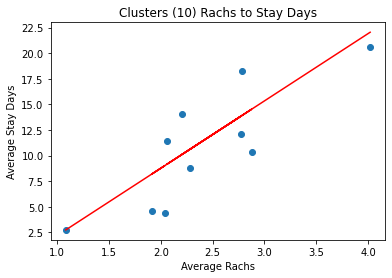

In [202]:
# Visualize Linear Regression on Clusters
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.title(f"Clusters ({N_CLUSTERS}) Rachs to Stay Days")
plt.xlabel("Average Rachs")
plt.ylabel("Average Stay Days")